In [1]:
# %pip install chex python_casacore einops

# Tensor Image Domain Gridding

Image Domain Gridding (IDG) is a fast method for convolutional resampling (gridding/degridding) of radio astronomical data (visibilities). It's highly parallel in natures making it suitable candidate for hardware accellerators like GPUs and FPGAs.

This is a tensor version of IDG written in JAX. This notebook contains the implementation of IDG as well reading the measurement set, upto creating a dirty image (currently in lmn, not in RA/DEC yet).

https://idg.readthedocs.io/en/latest/

## Modelling Computation as tensors

Linear algebra expressions can be represented elegantly in the tensor notation. A lot of modern numerical computation libraries offer an easy and performant ways to represent tensors and tensor operations like einsum. Modelling computation in this way keeps the code close to the domain, and makes it easy for a domain expert build new solutions.

JAX is a numerical computation library from Google that supports GPUs and TPUs. There are a wide variety of examples of JAX to create large scale ML models. JAX works equally well for creating harware accelerated simulations, and computation libraries.

**Matrix multiplication**

Einstein notation

$$
C_{ij} = A_{ik} B_{kj}
$$

Code

```py
C = np.einsum("ik,kj->ij", A, B)
```

**A more complex tensor contraction**

Einstein notation

$$
D_{ij} = A_{ijk} B_{jkx} C_{ijx}
$$

Code

```
A = np.randn(2, 3, 4)
B = np.randn(3, 4, 5)
C = np.randn(2, 3, 5)

Tensor reduction
np.einsum("ijk,jkx,ijx->ij", A, B, C)
```

**Gridding**

```
phase_off = jnp.broadcast_to(jnp.einsum("px,x->p", lmn, uvw_off), (NR_TIMESTEPS, NR_CHANNELS, NR_PIXELS))
phase_coefficient = jnp.einsum("px,tx,c->tcp", lmn, uvw, wave_numbers)
phase = phase_off - phase_coefficient
phasor = lax.complex(jnp.cos(phase), jnp.sin(phase)) # Calculate phasor
pixels = jnp.einsum("tcz,tcp->zp",visibilities,phasor) # Grid with visibilty

```


## Notes

1. Flagged rows (due to RFI, instrument issues) are not removed in this example notebook during gridding. This will affect the result when using a measurement set with flagged roms
2. This is only considering a single timeslot (all timesteps in the ms for a single baseline are grouped together)
3. The gridding function can be wrapped in a pmap to run across multiple devices
4. IDG plan calculation is pretty basic right now
5. 


# Obtaining the Data

Uncomment the cells below to download the measurement set. This is the same data used in IDGlib's validation

In [2]:
# !wget https://support.astron.nl/software/ci_data/IDG/MWA-1052736496-averaged.ms.tgz

In [3]:
# msin = "1934-638.ms"
# tarname = msin + ".tar.gz"

msin = "MWA-1052736496-averaged.ms"
tarname = msin + ".tgz"


In [4]:
# !tar -xf {tarname}

## Exploring the Measurement Set

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import casacore.tables
from casacore.tables import table
import signal
import argparse
import time
import jax
from jax import numpy as jnp
from jax import jit, vmap, lax
from functools import partial
import chex
from einops import rearrange
from typing import Tuple

Obtain all rows except the self correlations.

In [6]:
tb = casacore.tables.taql(f"SELECT * FROM {msin} WHERE ANTENNA1 != ANTENNA2")
# tb = table(f"{msin}", readonly=True,ack=False) # WHERE ANTENNA1 != ANTENNA2")

In [7]:
tb

UVW,FLAG,FLAG_CATEGORY,WEIGHT,SIGMA,ANTENNA1,ANTENNA2,ARRAY_ID,DATA_DESC_ID,EXPOSURE,FEED1,FEED2,FIELD_ID,FLAG_ROW,INTERVAL,OBSERVATION_ID,PROCESSOR_ID,SCAN_NUMBER,STATE_ID,TIME,TIME_CENTROID,DATA,WEIGHT_SPECTRUM,MODEL_DATA
"[-5.20128 m, 6.02037 m, 1.01487 m]","[[True, True, True, True], [True, True, True, True], [True, True, True, True], ..., [True, True, True, True], [True, True, True, True], [True, True, True, True]]",[],"[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]",1,2,0,0,4 s,0,0,0,False,4 s,0,-1,1,0,16-May-2013/10:48:01,16-May-2013/10:48:01,"[[0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], ..., [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..., [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]","[[(242.09691-51.742744j), (-16.970493+30.389967j), (-15.4834175+29.911303j), (242.09691-51.742744j)], [(242.09691-51.742744j), (-16.939148+30.392012j), (-15.451938+29.912886j), (242.09691-51.742744j)], [(242.09691-51.742744j), (-16.907852+30.394026j), (-15.420476+29.914446j), (242.09691-51.742744j)], ..., [(238.64635-63.036404j), (-5.881157+29.32945j), (-4.464364+28.754234j), (238.64635-63.036404j)], [(238.64635-63.036404j), (-5.8547616+29.321917j), (-4.4385104+28.74663j), (238.64635-63.036404j)], [(238.64635-63.036404j), (-5.828396+29.31434j), (-4.4126563+28.739016j), (238.64635-63.036404j)]]"
"[-12.2893 m, 16.1548 m, 2.00266 m]","[[True, True, True, True], [True, True, True, True], [True, True, True, True], ..., [True, True, True, True], [True, True, True, True], [True, True, True, True]]",[],"[1807.56, 1807.56, 1807.56, 1807.56]","[1.0, 1.0, 1.0, 1.0]",1,3,0,0,4 s,0,0,0,False,4 s,0,-1,1,0,16-May-2013/10:48:01,16-May-2013/10:48:01,"[[0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], ..., [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..., [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]","[[(207.96375-120.30953j), (4.1753745-11.49937j), (3.2175744-12.146098j), (207.96375-120.30953j)], [(207.96375-120.30953j), (4.133656-11.531138j), (3.1756823-12.17748j), (207.96375-120.30953j)], [(207.96375-120.30953j), (4.091836-11.56279j), (3.1336937-12.208735j), (207.96375-120.30953j)], ..., [(188.6212-142.05667j), (-16.387594-14.50814j), (-16.946098-14.501548j), (188.6212-142.05667j)], [(188.6212-142.05667j), (-16.445269-14.491468j), (-17.0021-14.482134j), (188.6212-142.05667j)], [(188.53712-142.12877j), (-16.502895-14.4746895j), (-17.058071-14.462612j), (188.53712-142.12877j)]]"
"[-2.9367 m, 22.7747 m, -4.01546 m]","[[True, True, True, True], [True, True, True, True], [True, True, True, True], ..., [True, True, True, True], [True, True, True, True], [True, True, True, True]]",[],"[5271.9575, 5271.9575, 5271.9575, 5271.9575]","[1.0, 1.0, 1.0, 1.0]",1,4,0,0,4 s,0,0,0,False,4 s,0,-1,1,0,16-May-2013/10:48:01,16-May-2013/10:48:01,"[[0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], ..., [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j]]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..., [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]","[[(225.30461-85.99768j), (3.3616502-1.7338476j), (2.9877245-2.0123487j), (225.30461-85.99768j)], [(225.30461-85.99768j), (3.3395996-1.7712841j), (2.9641454-2.0500903j), (225.30461-85.99768j)], [(225.2418-86.094574j), (3.3176243-1.8085986j), (2.940603-2.087783j), (225.2418-86.094574j)], ..., [(213.83682-102.585686j), (-9.760067-11.269021j), (-10.661517-11.5551815j), (213.83682-102.585686j)], [(213.76186-102.67261j), (-9.804379-11.278283j), (-10.706457-11.563749j), (213.76186-102.67261j)], [(213.76186-102.67261j), (-9.84856-11.287456j), (-10.751491-11.57223j), (213.76186-102.67261j)]]"
"[11.6153 m, 21.964 m, -10.5982 m]","[[True, True, True, True], [True, True, True, True], [True, True, True, True], ..., [True, True, True, True], [True, True, True, True], [True, True, True, Tru

Read the information about the spectral window

In [8]:
table_freq = table(f"{msin}/SPECTRAL_WINDOW", readonly=True,ack=False)

Read the antenna information

In [9]:
table_antenna = table(f"{msin}/ANTENNA", readonly=True,ack=False)

## Spectral information

In [10]:
ref_freq = table_freq.getcol("REF_FREQUENCY")
chan_width = table_freq.getcol("CHAN_WIDTH")
freqs = table_freq.getcol("CHAN_FREQ")[0]
nr_channels = freqs.size

Text(0, 0.5, 'Frequency (Hz)')

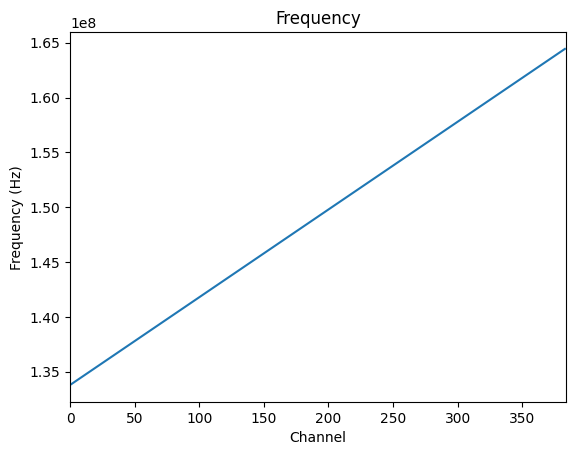

In [11]:
plt.plot(np.arange(nr_channels), freqs)
plt.xlim(0, nr_channels)
plt.title("Frequency")
plt.xlabel("Channel")
plt.ylabel("Frequency (Hz)")

## Antenna Metadata

In [12]:
positions = table_antenna.getcol("POSITION")
antenna_name = table_antenna.getcol("NAME")
nr_stations = len(antenna_name)

In [13]:
nr_stations

128

In [14]:
mean_sub_pos = positions - np.mean(positions, axis=0)
mean_sub_pos = np.column_stack([mean_sub_pos, np.arange(nr_stations)])

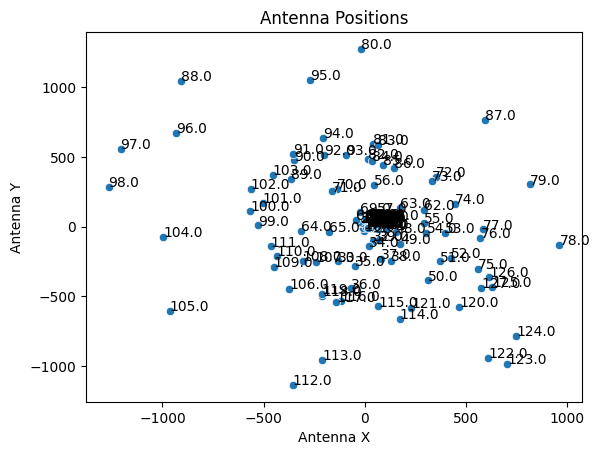

In [15]:
import seaborn as sns
import pandas as pd

# %matplotlib inline

df = pd.DataFrame(mean_sub_pos)

def plotlabel(xvar, yvar, label):
    ax.text(xvar+0.002, yvar+0.002, label)

ax = plt.subplot(111)
sns.scatterplot(ax=ax, data=df, x=0, y=2)
ax.set_xlabel("Antenna X")
ax.set_ylabel("Antenna Y")
ax.set_title("Antenna Positions")

df.apply(lambda x: plotlabel(x[0],  x[2], x[3]), axis=1)
# sns.move_legend(ax, "center right", bbox_to_anchor=(1.25, 0.5))

plt.show()

## UVW Track

In [16]:
uvw = tb.getcol("UVW")
raw_vis = tb.getcol("DATA")
flag = tb.getcol("FLAG")

station1 = tb.getcol("ANTENNA1")
station2 = tb.getcol("ANTENNA2")

In [17]:
baselines = np.column_stack([station1, station2])
baselines_unique = np.unique(baselines, axis=0)
baselines_unique.shape

nr_baselines = baselines_unique.shape[0]
nr_entries = raw_vis.shape[0]

nr_baselines, nr_entries

(2556, 71568)

In [18]:
def plot_uvw_track(uvw, comp=True):
    u_val = np.array([uvw_track[0] for uvw_track in uvw])
    v_val = np.array([uvw_track[1] for uvw_track in uvw])

    plt.plot( u_val,  v_val, ".")
    if comp:
        plt.plot(-u_val, -v_val, ".")
    plt.title("UV Coverage")
    plt.xlabel("U")
    plt.ylabel("V")

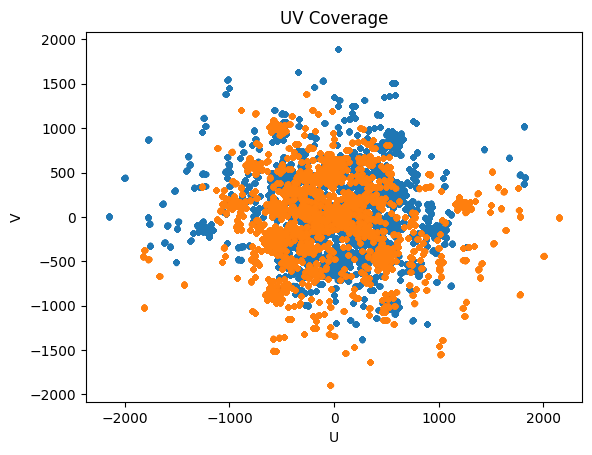

In [19]:
plot_uvw_track(uvw)

## Visibilites

In [20]:
def get_figure_name(name):
    return "Figure %d: %s" % (len(plt.get_fignums()) + 1, name)

def plot_visibilities(visibilities, form='abs'):
    if form == 'angle':
        visXX = np.angle(visibilities[:, :, 0].flatten())
        visXY = np.angle(visibilities[:, :, 1].flatten())
        visYX = np.angle(visibilities[:, :, 2].flatten())
        visYY = np.angle(visibilities[:, :, 3].flatten())
        title = "Angle"
    elif form == 'real':
        visXX = np.real(visibilities[:, :, 0].flatten())
        visXY = np.real(visibilities[:, :, 1].flatten())
        visYX = np.real(visibilities[:, :, 2].flatten())
        visYY = np.real(visibilities[:, :, 3].flatten())
        title = "Real"
    elif form == 'imag':
        visXX = np.imag(visibilities[:, :, 0].flatten())
        visXY = np.imag(visibilities[:, :, 1].flatten())
        visYX = np.imag(visibilities[:, :, 2].flatten())
        visYY = np.imag(visibilities[:, :, 3].flatten())
        title = "Imag"
    else:
        visXX = np.abs(visibilities[:, :, 0].flatten())
        visXY = np.abs(visibilities[:, :, 1].flatten())
        visYX = np.abs(visibilities[:, :, 2].flatten())
        visYY = np.abs(visibilities[:, :, 3].flatten())
        title = "Abs"

    fig, axarr = plt.subplots(2, 2, num=get_figure_name("visibilities"))
    fig.suptitle(f"Visibilites {title}", fontsize=14)

    axarr[0, 0].plot(visXX)
    axarr[0, 1].plot(visXY)
    axarr[1, 0].plot(visYX)
    axarr[1, 1].plot(visYY)

    axarr[0, 0].set_title('XX')
    axarr[0, 1].set_title('XY')
    axarr[1, 0].set_title('YX')
    axarr[1, 1].set_title('YY')

    axarr[0, 0].tick_params(axis='both',
                          which='both',
                          bottom=False,
                          top=False,
                          labelbottom=False)

    axarr[0, 1].tick_params(axis='both',
                          which='both',
                          bottom=False,
                          top=False,
                          labelbottom=False)

    axarr[1, 0].tick_params(axis='both',
                          which='both',
                          bottom=False,
                          top=False,
                          labelbottom=False)

    axarr[1, 1].tick_params(axis='both',
                          which='both',
                          bottom=False,
                          top=False,
                          labelbottom=False)

    plt.tight_layout()


# Image Domain Gridding

## Modelling as tensors

Image Domain Gridding is a convolutional resampling algorithm

$$
\widehat{I_p}(l, m) = \sum y_{pk} e^{2 \pi i (u_{pk} - u_{op})l +(v_{pk} - v_{op})m + (w_{pk}n)} c_{pk}(l, m)
$$

Aterm correction is given as

$$
P_{a} = Aterm_1 . (P . Aterm_2^H)
$$


## Utilities

In [21]:
@chex.dataclass
class Metadata:
    baseline_offset: jnp.int64
    time_offset: jnp.int64
    nr_timesteps: jnp.int64
    aterm_index: jnp.int64
    baseline: Tuple[jnp.int64, jnp.int64]
    coordinate: Tuple[jnp.int64, jnp.int64, jnp.int64]

In [22]:
image_size = 0.2
grid_size = 512

cell_size = grid_size / image_size
subgrid_size = 32
timesteps = 32

nr_timesteps = nr_entries // nr_baselines
nr_pixels = subgrid_size * subgrid_size

In [23]:
def compute_l(x, subgrid_size, image_size):
    return (x+0.5-(subgrid_size/2)) * image_size/subgrid_size

def compute_m(y, subgrid_size, image_size):
    return compute_l(y, subgrid_size, image_size)

def compute_n(l, m):
    """
    evaluate n = 1.0f - sqrt(1.0 - (l * l) - (m * m));
    accurately for small values of l and m
    """
    tmp = (l * l) + (m * m)
    return np.where(tmp > 1.0, 1.0, tmp / (1.0 + np.sqrt(1.0 - tmp)))

def compute_lmn(subgrid_size, image_size):
    x, y = np.meshgrid(np.arange(subgrid_size), np.arange(subgrid_size))
    x = x.reshape(subgrid_size * subgrid_size)
    y = y.reshape(subgrid_size * subgrid_size)
    l = compute_l(x, subgrid_size, image_size)
    m = compute_m(y, subgrid_size, image_size)
    n = compute_n(l, m)
    return rearrange(np.stack([l,m,n]), "x p -> p x")


In [24]:
def init_identity_aterm(nr_stations):
    aterm_ident = np.array([[1.0 + 0.0j, 0.0 + 0.0j], [0.0 + 0.0j, 1.0 + 0.0j]])
    return np.full((nr_stations, nr_pixels, 2, 2), aterm_ident)

In [25]:
# Taken from idg-util/src/python/util.py, Modified slightly

def evaluate_spheroidal(nu):
    """Function to compute spheroidal
        Based on libreSpheroidal function in CASA
        https://github.com/radio-astro/casa/blob/4ebd5b1508a5d31b74e7b5f6b89313368d30b9ef/code/synthesis/TransformMachines/Utils.cc#L776"""
    P = np.array(
        [[8.203343e-2, -3.644705e-1, 6.278660e-1, -5.335581e-1, 2.312756e-1],
         [4.028559e-3, -3.697768e-2, 1.021332e-1, -1.201436e-1, 6.412774e-2]])
    Q = np.array([[1.0000000e0, 8.212018e-1, 2.078043e-1],
                     [1.0000000e0, 9.599102e-1, 2.918724e-1]])

    part = 0
    end = 0.0

    if (nu >= 0.0 and nu < 0.75):
        part = 0
        end = 0.75
    elif (nu >= 0.75 and nu <= 1.00):
        part = 1
        end = 1.00
    else:
        return 0.0

    nusq = nu * nu
    delnusq = nusq - end * end
    delnusqPow = delnusq
    top = P[part][0]
    for k in range(1, 5):
        top += P[part][k] * delnusqPow
        delnusqPow *= delnusq

    bot = Q[part][0]
    delnusqPow = delnusq
    for k in range(1, 3):
        bot += Q[part][k] * delnusqPow
        delnusqPow *= delnusq

    if bot == 0:
        result = 0
    else:
        result = (1.0 - nusq) * (top / bot)
    return result


def make_gaussian(size, fwhm=3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4 * np.log(2) * ((x - x0)**2 + (y - y0)**2) / fwhm**2)


def compute_taper_subgrid(subgrid_size, taper_type='spheroidal'):
    """
    Creates taper for grid
    taper_type = 'spheroidal'  | 'gaussian' | 'ones'
    """
    if taper_type == 'spheroidal':
        # Construct taper for subgrid
        # Spheroidal from Bas
        x = np.array(np.abs(
            np.linspace(-1, 1, num=subgrid_size, endpoint=False)),
                        dtype=np.float32)
        x = np.array([evaluate_spheroidal(e) for e in x], dtype=np.float32)
        taper = x[np.newaxis, :] * x[:, np.newaxis]
        return taper
    elif taper_type == "gaussian":
        return make_gaussian(subgrid_size, int(subgrid_size * 0.3))

    return np.ones((subgrid_size, subgrid_size), dtype = np.float32)

In [26]:
speed_of_light = 299792458.0

def compute_wavenumber(frequencies):
    return (frequencies * 2 * np.pi) / speed_of_light

In [27]:
block_size = nr_timesteps * nr_baselines
nr_timeslots = nr_entries // block_size
nr_timesteps, block_size, nr_timeslots

(28, 71568, 1)

In [28]:
for slot in range(1):
    st = block_size * slot
    en = st + block_size
    print(st, en)
    uvw_block = rearrange(uvw[st:en], "(t b) v -> b t v", t=nr_timesteps, b=nr_baselines, v=3)
    vis_block = rearrange(raw_vis[st:en], "(t b) ch corr -> b t ch corr", t=nr_timesteps, b=nr_baselines)
    baselines_block = rearrange(baselines[st:en], "(t b) v -> b t v", t=nr_timesteps, b=nr_baselines)


0 71568


In [29]:
baseline = 0

In [30]:
uvw_split = rearrange(uvw_block[0], "t v -> v t ")



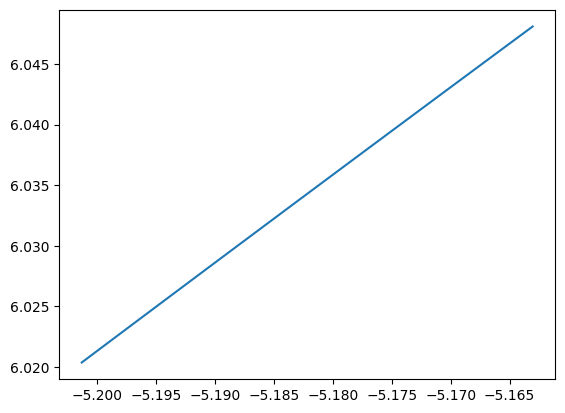

In [31]:
plt.plot(uvw_split[0], uvw_split[1])

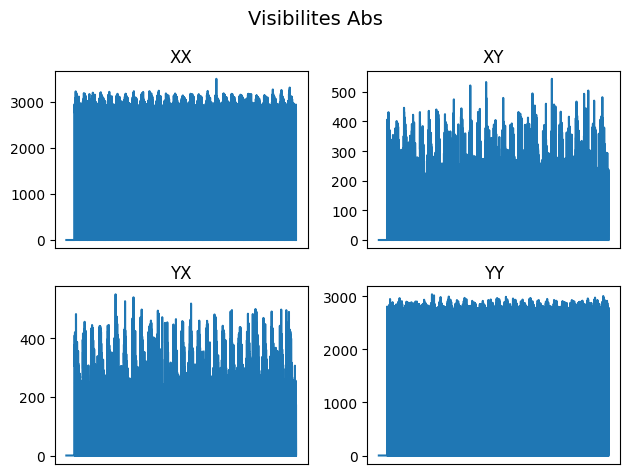

In [32]:
plot_visibilities(vis_block[0])

In [33]:
class Subgrid:
    def __init__(self, kernel_size, subgrid_size, grid_size, wtile_size):
        self.reset()
        self.kernel_size = kernel_size
        self.subgrid_size = subgrid_size
        self.grid_size = grid_size
        self.wtile_size = wtile_size

    def reset(self):
        self.u_min = np.inf
        self.u_max = -np.inf
        self.v_min = np.inf
        self.v_max = -np.inf
        self.uv_width = 0
        self.w_index = 0
        self.coordinate = (0, 0, 0)

    # TODO: Add checks for NaN
    # TODO: Add handling for W index
    def add_vis(self, u_pixels, v_pixels, w_lambda):
        u_min = self.u_min if self.u_min < u_pixels else u_pixels
        v_min = self.v_min if self.v_min < v_pixels else v_pixels

        u_max = self.u_max if self.u_max > u_pixels else u_pixels
        v_max = self.v_max if self.v_max > v_pixels else v_pixels

        u_width = u_max - u_min
        v_width = v_max - v_min
        uv_width = u_width if u_width > v_width else v_width

        if uv_width + self.kernel_size >= self.subgrid_size:
            return False
        else:
            self.u_min = u_min
            self.u_max = u_max
            self.v_min = v_min
            self.v_max = v_max
            self.w_index = 0
            self.uv_width = uv_width
            return True

    def compute_coordinate(self):
        # Compute middle point in pixels
        u_pixels = np.round((self.u_max + self.u_min) / 2);
        v_pixels = np.round((self.v_max + self.v_min) / 2);

        wtile_x = np.floor(u_pixels / self.wtile_size);
        wtile_y = np.floor(v_pixels / self.wtile_size);

        # Shift center from middle of grid to top left
        u_pixels += (grid_size / 2);
        v_pixels += (grid_size / 2);

        # Shift from middle of subgrid to top left
        u_pixels -= (subgrid_size / 2);
        v_pixels -= (subgrid_size / 2);

        self.coordinate = (u_pixels, v_pixels, self.w_index);
        # Not used
        self.wtile_coordinate = (wtile_x, wtile_y, self.w_index);

        return self.coordinate


In [34]:
m_w_step = 1.0
freq_begin = freqs[0]
freq_end = freqs[-1]

scale_begin = freq_begin / speed_of_light
scale_end = freq_end / speed_of_light
scale_w = 1.0 / m_w_step

nr_timesteps_per_subugrid = nr_timesteps

In [35]:
def create_plan(uvw, baselines, grid_size, nr_baselines, nr_timeslots, nr_timesteps_subgrid):
    metadata = []
    subgrid = Subgrid(subgrid_size//2, subgrid_size, grid_size, 128)

    for bl in range(nr_baselines):
        baseline = baselines[bl][0]
        aterm_index = 0          # Find how to create this
        baseline_offset = 0
        offset = 0
        time_offset = 0

        subgrid.reset()
        # TODO: Handle multiple timeslots

        for ts in range(nr_timesteps):
            t = time_offset + ts
            u_pixels_begin = uvw_block[bl][t][0] * image_size * scale_begin
            v_pixels_begin = uvw_block[bl][t][1] * image_size * scale_begin
            w_lambda_begin = uvw_block[bl][t][2] * scale_begin * scale_w

            u_pixels_end = uvw_block[bl][t][0] * image_size * scale_end
            v_pixels_end = uvw_block[bl][t][1] * image_size * scale_end
            w_lambda_end = 0.0

            subgrid.add_vis(u_pixels_begin, v_pixels_begin, w_lambda_begin)
            subgrid.add_vis(u_pixels_end, v_pixels_end, w_lambda_end)

        coordinate = subgrid.compute_coordinate()
        # print(subgrid.uv_width)

        metadata.append(Metadata(
            baseline_offset=baseline_offset,
            time_offset=time_offset,
            nr_timesteps=nr_timesteps_subgrid,
            aterm_index=aterm_index,
            baseline=baseline,
            coordinate=coordinate
        ))

    return metadata

In [36]:
lmn = compute_lmn(subgrid_size, image_size)
plan = create_plan(uvw_block, baselines_block, grid_size, nr_baselines, nr_timeslots, nr_timesteps)
taper = compute_taper_subgrid(subgrid_size)
# taper = compute_taper_subgrid(subgrid_size, taper_type="ones")
# taper = compute_taper_subgrid(subgrid_size, taper_type="gaussian")
aterm = init_identity_aterm(nr_stations)
wavenumbers = compute_wavenumber(freqs)

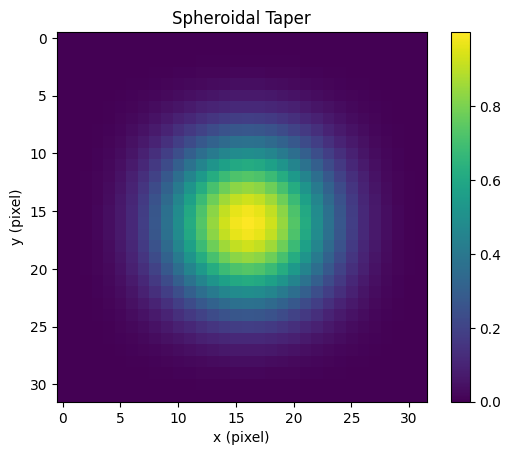

In [37]:
plt.title("Spheroidal Taper")
plt.imshow(taper)
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.colorbar()

In [38]:
coordinates = np.array([p.coordinate for p in plan])

coordinates_T = coordinates.T

Text(0.5, 1.0, 'Subgrid origin')

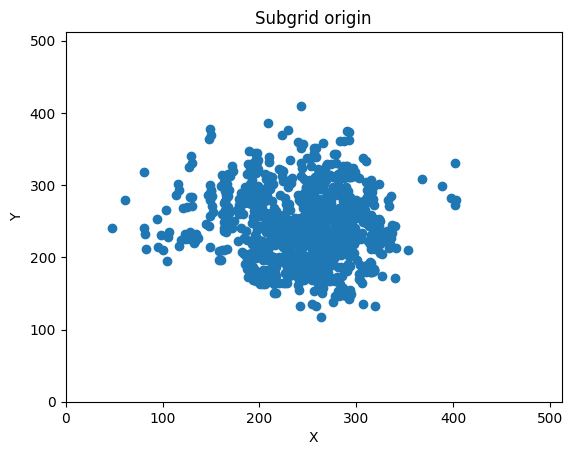

In [39]:
plt.scatter(coordinates_T[0], coordinates_T[1])
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([0, grid_size])
plt.ylim([0, grid_size])
plt.title("Subgrid origin")

## Transfer Data to the Device

In [40]:
lmn = jnp.asarray(lmn)
taper = jnp.asarray(taper).reshape(subgrid_size * subgrid_size)
aterm = jnp.asarray(aterm)
wavenumbers = jnp.asarray(wavenumbers)

### Aterm Correction

In [41]:
@jit
@partial(vmap, in_axes=(1,0,0), out_axes=1)
def aterm_gridding(pixels, aterm1, aterm2):
    """
    pixels: (4,)
    aterm1: (2,2,)
    aterm2: (2,2,)

    return: (4,)
    """
    pixels = pixels.reshape(2, 2)
    temp = jnp.conj(aterm1).T @ pixels
    temp = temp @ aterm2
    return temp.reshape(4)

@jit
@partial(vmap, in_axes=(1,0,0), out_axes=1)
def aterm_degridding(pixels, aterm1, aterm2):
    """
    pixels: (4,)
    aterm1: (2,2,)
    aterm2: (2,2,)

    return: (4,)
    """
    pixels = pixels.reshape(2, 2)
    temp = aterm1 @ pixels
    temp = pixels @ jnp.conj(aterm2).T
    return temp.reshape(4)

### Gridding

In [42]:
@jit
@partial(vmap, in_axes=(0, None, 0, 0, None, None, None, None), out_axes=0)
def gridding(visibilities, lmn, uvw, uvw_off, wave_numbers, taper, aterm1, aterm2):
    phase_off = jnp.broadcast_to(jnp.einsum("px,x->p", lmn, uvw_off), (nr_timesteps, nr_channels, 1024))
    phase_coefficient = jnp.einsum("px,tx,c->tcp", lmn, uvw, wave_numbers)
    phase = phase_off - phase_coefficient
    phasor = lax.complex(jnp.cos(phase), jnp.sin(phase)) # Calculate phasor
    pixels = jnp.einsum("tcz,tcp->zp",visibilities,phasor) # Grid with visibilty

    aterm_corrected = aterm_gridding(pixels, aterm1, aterm2) # A-Term Correction

    subgrid = jnp.einsum("zp,p->zp", aterm_corrected, taper) # Apply tapering

    return subgrid

### Degridding

In [43]:
@jit
@partial(vmap, in_axes=(0, None, 0, 0, None, None, None, None), out_axes=0)
def degridding(subgrid, lmn, uvw, uvw_off, wave_numbers, taper, aterm1, aterm2):
    tapered_subgrid = jnp.einsum("zp,p->zp", subgrid, taper) # Apply tapering

    pixels = aterm_degridding(tapered_subgrid, aterm1, aterm2)

    phase_off = jnp.broadcast_to(jnp.einsum("px,x->p", lmn, uvw_off), (nr_timesteps, nr_channels, 1024))
    phase_coefficient = jnp.einsum("px,tx,c->tcp", lmn, uvw, wave_numbers)
    phase = phase_coefficient - phase_off
    phasor = lax.complex(jnp.cos(phase), jnp.sin(phase)) # Calculate phasor

    visibilities = jnp.einsum("tcp,zp->tcz", phasor, pixels)
    return visibilities


## Dirty Image Creatio

In [44]:
visibilities = jnp.asarray(vis_block)
uvw_d = jnp.asarray(uvw_block)
coordinates_d = jnp.asarray(coordinates)

In [45]:
def grid_ms(lmn, uvw_d, visibilities, coordinates_d, taper, aterm):
    grid = np.zeros((4, grid_size, grid_size), dtype=np.complex_)
    gridding_batch_size = 8

    # TODO: This could also be a JAX function
    for batch in range(int(np.ceil(nr_baselines / gridding_batch_size))):
        # for batch in range(5):
        st = gridding_batch_size * batch
        en = min(gridding_batch_size * (batch+1), nr_baselines)
        baselines = np.arange(st, en)

        baseline_coordinates = coordinates_d[baselines].T
        w_step = 0.0

        x_coordinate = baseline_coordinates[0]
        y_coordinate = baseline_coordinates[1]
        w_offset_in_lamba = w_step * (baseline_coordinates[2] + 0.5)

        u_offset = (x_coordinate + subgrid_size/2 - grid_size/2) * (2 * jnp.pi / image_size)
        v_offset = (y_coordinate + subgrid_size/2 - grid_size/2) * (2 * jnp.pi / image_size)
        w_offset = 2*jnp.pi * w_offset_in_lamba

        uvw_off = jnp.array([u_offset, v_offset, w_offset]).T

        subgrids = gridding(visibilities[baselines], lmn, uvw_d[baselines], uvw_off, wavenumbers, taper, aterm[0], aterm[1])

        subgrids = jnp.fft.ifft2(rearrange(subgrids, "s z (px py) -> s z px py", px=32, py=32), axes=(2, 3))

        X, Y = jnp.meshgrid(jnp.arange(subgrid_size), jnp.arange(subgrid_size))

        phase = jnp.pi*(X + Y - subgrid_size) / subgrid_size
        phasor = jnp.cos(phase) + 1j * jnp.sin(phase)

        # Add subgrids into main grid
        for idx, (x_coor, y_coor) in enumerate(zip(x_coordinate, y_coordinate)):
            if (x_coor >= 0 and x_coor < grid_size - subgrid_size and
                y_coor >= 0 and y_coor < grid_size - subgrid_size):
                X_src = int(x_coor) + ((X + subgrid_size//2) % subgrid_size)
                Y_src = int(y_coor) + ((Y + subgrid_size//2) % subgrid_size)
                for pol in range(4):
                    grid[pol, X_src, Y_src] += phasor * subgrids[idx][pol]

    return grid

In [46]:
grid = grid_ms(lmn, uvw_d, visibilities, coordinates_d, taper, aterm)

In [47]:
colormap = plt.get_cmap('viridis')

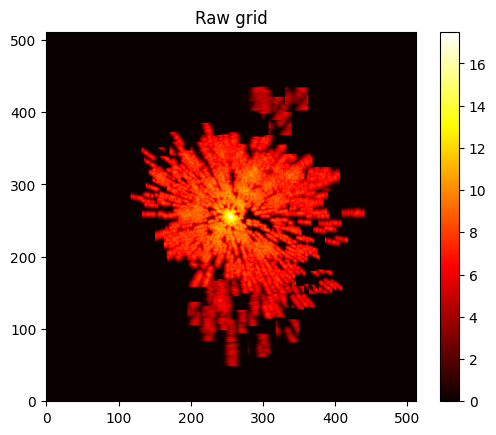

In [48]:
plt.imshow(np.log(np.abs(grid[0]) + 1), cmap=plt.get_cmap('hot'), origin='lower')
plt.title("Raw grid")
plt.colorbar()

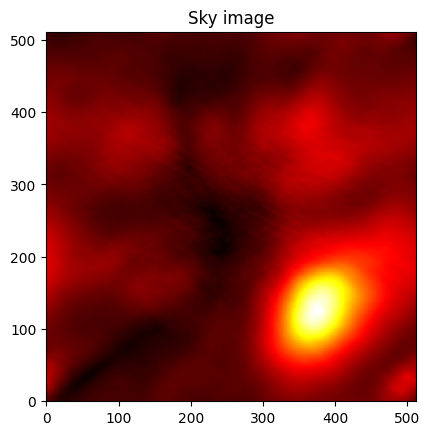

In [66]:
dirty_image = np.abs(np.fft.fft2(grid[0]))
dirty_image_crop = dirty_image[int(grid_size*0.1):int(grid_size*0.9),int(grid_size*0.1):int(grid_size*0.9)]

m = np.amax(dirty_image)
plt.title("Sky image")
plt.imshow(dirty_image, interpolation='nearest', cmap=plt.get_cmap('hot'), origin='lower')
# plt.xlabel("$l$ [degrees]")
# plt.xlabel("$m$ [degrees]")


### Direction Cosine Coordinates to equatorial coordinates

Field center $(\alpha_0, \delta_0) = (8hrs20min, -42^o53') $

> Note: I have manually used the approx field center taken from imaging with wsclean

$$ 
\alpha_{rad} = \frac{\pi}{12} (h + \frac{m}{60} + \frac{s}{3600}) \\
\delta_{rad} = \frac{\pi}{180} (d + \frac{m_{arcmin}}{60} + \frac{s_{arcsec}}{3600})
$$

Convertion to equatorial coordinates

$$
\delta = sin^{-1}(m cos\delta_0 + sin \delta_o \sqrt{1 - l^2 - m^2}) \\
\alpha = \alpha_0 + tan^{-1}(\frac{l}{cos \delta_o \sqrt{1 - l^2 - m^2}})
$$


Coordinate conversion ref: 
http://math_research.uct.ac.za/~siphelo/admin/interferometry/3_Positional_Astronomy/3_4_Direction_Cosine_Coordinates.html

In [51]:
# 8hr20min, -42deg 53
# TODO: Maybe have this in astropy rather than variables
pt_ra_hr = 8
pt_ra_min = 20

pt_dec_deg = -42
pt_deg_min = 53

pt_ra_rad = (np.pi / 12) * (pt_ra_hr + pt_ra_min / 60)
pt_dec_rad = (np.pi / 180) * (-42 + 53 / 60)

pt_ra_rad, pt_dec_rad

(2.181661564992912, -0.7176212107783352)

In [71]:
_lmn_grid = compute_lmn(grid_size, image_size)
lmn_grid = rearrange(_lmn_grid, "(sz1 sz2) v -> v sz1 sz2", sz1=grid_size, sz2=grid_size, v=3)

In [ ]:
delta = np.arcsin()

In [77]:
lmn_grid[0]

array([[-0.09980469, -0.09941406, -0.09902344, ...,  0.09902344,
         0.09941406,  0.09980469],
       [-0.09980469, -0.09941406, -0.09902344, ...,  0.09902344,
         0.09941406,  0.09980469],
       [-0.09980469, -0.09941406, -0.09902344, ...,  0.09902344,
         0.09941406,  0.09980469],
       ...,
       [-0.09980469, -0.09941406, -0.09902344, ...,  0.09902344,
         0.09941406,  0.09980469],
       [-0.09980469, -0.09941406, -0.09902344, ...,  0.09902344,
         0.09941406,  0.09980469],
       [-0.09980469, -0.09941406, -0.09902344, ...,  0.09902344,
         0.09941406,  0.09980469]])

In [62]:
lmn_grid

array([[-0.09980469, -0.09980469,  0.01001109],
       [-0.09941406, -0.09980469,  0.00997178],
       [-0.09902344, -0.09980469,  0.00993264],
       ...,
       [ 0.09902344,  0.09980469,  0.00993264],
       [ 0.09941406,  0.09980469,  0.00997178],
       [ 0.09980469,  0.09980469,  0.01001109]])

In [67]:
lmn_subgrid = compute_lmn(subgrid_size, image_size)
lmn_subgrid.shape

(1024, 3)

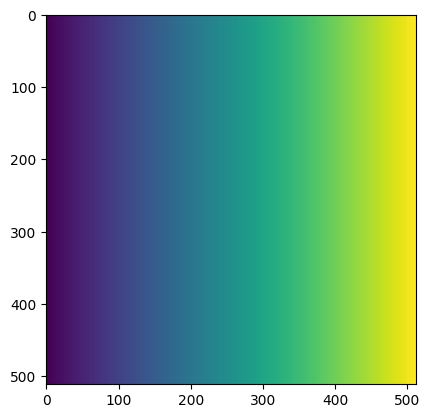

In [78]:
plt.imshow(lmn_grid[0])

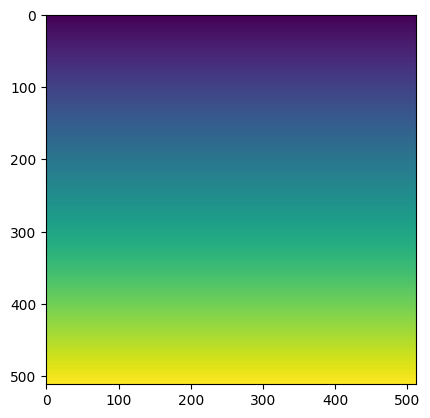

In [79]:
plt.imshow(lmn_grid[1])

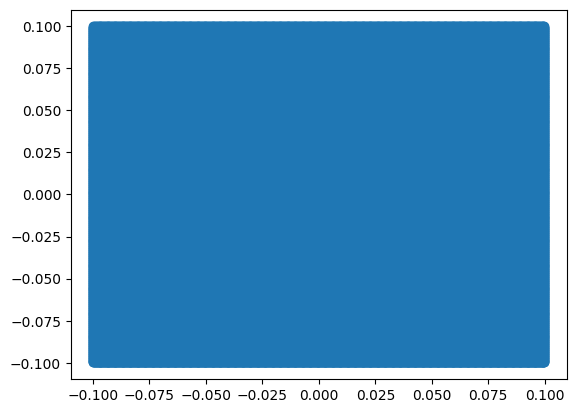

In [80]:
plt.scatter(lmn_grid[0], lmn_grid[1])